In [ ]:
# imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import re
from string import punctuation
from nltk.tokenize import ToktokTokenizer
from bs4 import BeautifulSoup
from wordcloud import WordCloud, STOPWORDS
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords
import nltk
import os

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

from keras.preprocessing.text import Tokenizer
from keras.models import Sequential, Model
from keras.layers import Activation, Dense, Dropout
from sklearn.preprocessing import  MultiLabelBinarizer
import sklearn.datasets as skds
from pathlib import Path
import itertools
from sklearn.metrics import confusion_matrix

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# to read dataset using pandas
def load_data(path):
  return pd.read_csv(path, encoding="ISO-8859-1")

# to get dataset after merging questions data and tags
def get_dataset():
  question_path ="/content/drive/My Drive/NLP-Classification-project/data/Questions.csv"
  tags_path = "/content/drive/My Drive/NLP-Classification-project/data/Tags.csv"
  
  # questions data operations
  question_data = load_data(question_path)
  question_data.drop(columns=['OwnerUserId', 'CreationDate', 'ClosedDate'], inplace=True)  # dropping unwanted columns 
 
  # tags data operations
  tags_data = load_data(tags_path)
  tags_data['Tag'] = tags_data['Tag'].astype(str)                                           # converting to type string 
  grouped_tags = tags_data.groupby("Id")['Tag'].apply(lambda tags: ' '.join(tags))          # grouping tags based on ID's 
  grouped_tags_final = pd.DataFrame({'Id':grouped_tags.index, 'Tags':grouped_tags.values})  # converting series to dataframe
  
  data = question_data.merge(grouped_tags_final, on='Id')                                   # merging questions and tags

  return data



In [ ]:
data = get_dataset()
data

,Id,Score,Title,Body,Tags
0,80,26,SQLStatement.execute() - multiple queries in o...,<p>I've written a database generation script i...,flex actionscript-3 air
1,90,144,Good branching and merging tutorials for Torto...,<p>Are there any really good tutorials explain...,svn tortoisesvn branch branching-and-merging
2,120,21,ASP.NET Site Maps,<p>Has anyone got experience creating <strong>...,sql asp.net sitemap
3,180,53,Function for creating color wheels,<p>This is something I've pseudo-solved many t...,algorithm language-agnostic colors color-space
4,260,49,Adding scripting functionality to .NET applica...,<p>I have a little game written in C#. It uses...,c# .net scripting compiler-construction
...,...,...,...,...,...
1264211,40143210,0,URL routing in PHP (MVC),<p>I am building a custom MVC project and I ha...,php .htaccess
1264212,40143300,0,Bigquery.Jobs.Insert - Resumable Upload?,<p>The API docs show that you should be able t...,google-bigquery
1264213,40143340,1,Obfuscating code in android studio,<p>Under minifyEnabled I changed from false to...,android android-studio
1264214,40143360,0,How to fire function after v-model change?,<p>I have input which I use to filter my array...,javascript vue.js


In [ ]:
type(data)

pandas.core.frame.DataFrame

In [ ]:
data['Tags'] = data['Tags'].apply(lambda x: x.split())

In [ ]:
data["tag_count"] = data["Tags"].apply(len)

In [ ]:
class Tags:
  def __init__(self,dataset):
    self.data =  dataset
    self.all_tags = [item for sublist in dataset['Tags'].values for item in sublist]
    self.unique_tags = list(set(self.all_tags))
    self.keywords = nltk.FreqDist(self.all_tags)


  def all_tags_counts(self):
    print("Total no.of tags in dataset: "+str(len(self.all_tags)))

  def unique_tag_count(self):
    print("Unique no.of tags in dataset: "+str(len(self.unique_tags)))

  def get_common_features(self,frequency):
    frequencies_words = self.keywords.most_common(frequency)
    return frequencies_words

  def plot_top_frequencies(self,frequency):
    fig, ax = plt.subplots(figsize=(10, 7))
    self.keywords.plot(frequency, cumulative=False)

  def wordcount(self,frequency):
    tags_features = [word[0] for word in self.get_common_features(frequency)]
    tags_string = ' '.join(tags_features).lower()
    wordcloud = WordCloud(max_font_size=50, max_words=100).generate(tags_string)
    plt.figure(figsize=(15,7))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

  def frequency_pie(self,frequency):
    common_features = self.get_common_features(frequency)
    tags_features = [word[0] for word in common_features]
    tags_frequency = [word[1] for word in common_features]
    fig = plt.figure(figsize =(10, 7))
    plt.pie(tags_frequency, labels = tags_features)
    plt.show()

  def freq(self):
    t_fre = [0,0,0,0,0]
    for item in self.data['tag_count']:
      t_fre[item-1]+=1
    t_lab = [1,2,3,4,5]
    fig = plt.figure(figsize =(10, 7))
    plt.pie(t_fre,labels = t_lab, autopct='%1.1f%%', explode=[0.1,0.1,0.2,0.1,0.1], shadow=True, startangle=90)
    plt.title('length of tags')
    plt.show()




In [ ]:
tags = Tags(data)
tags.all_tags_counts()
tags.unique_tag_count()

Total no.of tags in dataset: 3750994
Unique no.of tags in dataset: 37035


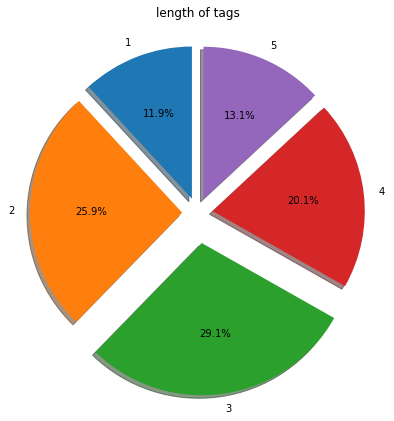

In [ ]:
tags.freq()

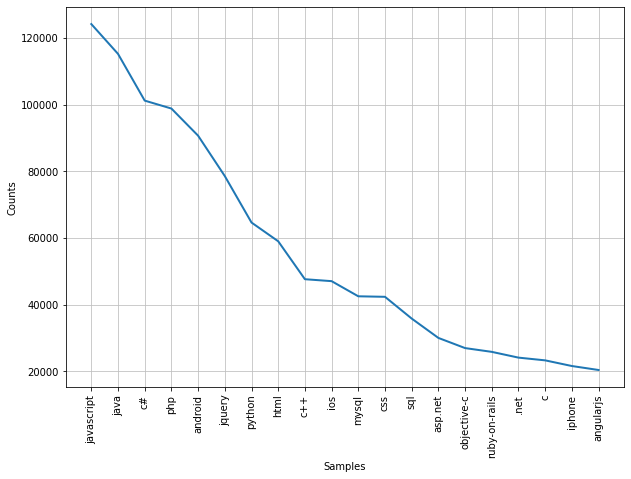

In [ ]:
tags.plot_top_frequencies(20)

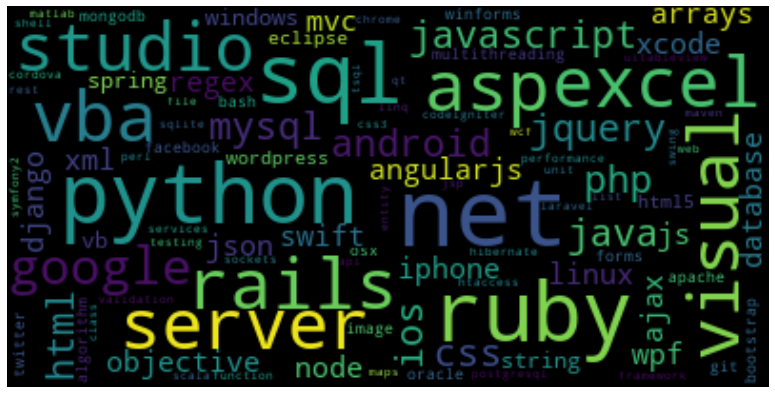

In [ ]:
tags.wordcount(100)


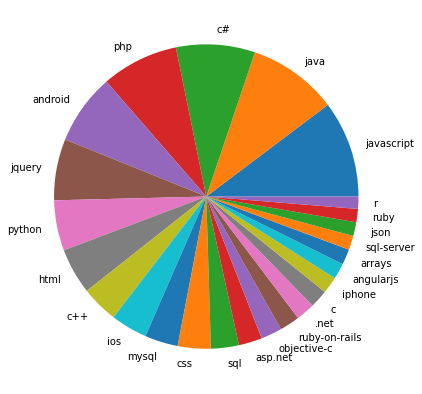

In [ ]:
tags.frequency_pie(25)

In [ ]:
tags_features = [word[0] for word in tags.get_common_features(100)]

In [ ]:
data

,Id,Score,Title,Body,Tags,tag_count
0,80,26,SQLStatement.execute() - multiple queries in o...,<p>I've written a database generation script i...,"[flex, actionscript-3, air]",3
1,90,144,Good branching and merging tutorials for Torto...,<p>Are there any really good tutorials explain...,"[svn, tortoisesvn, branch, branching-and-merging]",4
2,120,21,ASP.NET Site Maps,<p>Has anyone got experience creating <strong>...,"[sql, asp.net, sitemap]",3
3,180,53,Function for creating color wheels,<p>This is something I've pseudo-solved many t...,"[algorithm, language-agnostic, colors, color-s...",4
4,260,49,Adding scripting functionality to .NET applica...,<p>I have a little game written in C#. It uses...,"[c#, .net, scripting, compiler-construction]",4
...,...,...,...,...,...,...
1264211,40143210,0,URL routing in PHP (MVC),<p>I am building a custom MVC project and I ha...,"[php, .htaccess]",2
1264212,40143300,0,Bigquery.Jobs.Insert - Resumable Upload?,<p>The API docs show that you should be able t...,[google-bigquery],1
1264213,40143340,1,Obfuscating code in android studio,<p>Under minifyEnabled I changed from false to...,"[android, android-studio]",2
1264214,40143360,0,How to fire function after v-model change?,<p>I have input which I use to filter my array...,"[javascript, vue.js]",2


In [ ]:
data["Score"].max()

5190

In [ ]:
def drop_WRT_score(score,data):
  data = data[data['Score']>score]
  data.drop(columns=['Id', 'Score','tag_count'], inplace=True)
  return data

In [ ]:
data = drop_WRT_score(20,data)
data

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,Title,Body,Tags
0,SQLStatement.execute() - multiple queries in o...,<p>I've written a database generation script i...,"[flex, actionscript-3, air]"
1,Good branching and merging tutorials for Torto...,<p>Are there any really good tutorials explain...,"[svn, tortoisesvn, branch, branching-and-merging]"
2,ASP.NET Site Maps,<p>Has anyone got experience creating <strong>...,"[sql, asp.net, sitemap]"
3,Function for creating color wheels,<p>This is something I've pseudo-solved many t...,"[algorithm, language-agnostic, colors, color-s..."
4,Adding scripting functionality to .NET applica...,<p>I have a little game written in C#. It uses...,"[c#, .net, scripting, compiler-construction]"
...,...,...,...
1235494,Strange Java behaviour with static and final q...,<p>In our team we found some strange behaviour...,"[java, order, final]"
1238365,SMTP configuration not working in production,<p>I'm trying to send an email when a form is ...,"[php, email, smtp, phpmailer]"
1240566,"Since Xcode 8 and iOS10, views are not sized p...","<p>It seems that with Xcode 8, on <code>viewDi...","[ios, autolayout, ios10, xcode8]"
1243077,What precautions should I take to make a memor...,"<p>My initial problem is that I have, on a pro...","[c, language-lawyer, undefined-behavior, c11, ..."


In [ ]:
token=ToktokTokenizer()

In [ ]:
data["question"] = data["Title"]+" "+data["Body"]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
def remove_HTMLformat():
  data['question'] = data['question'].apply(lambda x: BeautifulSoup(x).get_text()) 

In [ ]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "can not ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r"\'scuse", " excuse ", text)
    text = re.sub(r"\'\n", " ", text)
    text = re.sub(r"\'\xa0", " ", text)
    text = re.sub('\s+', ' ', text)
    text = text.strip(' ')
    return text

In [ ]:
def strip_list_noempty(mylist):
    newlist = (item.strip() if hasattr(item, 'strip') else item for item in mylist)
    return [item for item in newlist if item != '']

In [ ]:
def clean_punct(text): 
    words=token.tokenize(text)
    punctuation_filtered = []
    regex = re.compile('[%s]' % re.escape(punctuation))
    remove_punctuation = str.maketrans(' ', ' ', punctuation)
    for w in words:
        if w in tags_features:
            punctuation_filtered.append(w)
        else:
            punctuation_filtered.append(regex.sub('', w))
  
    filtered_list = strip_list_noempty(punctuation_filtered)
        
    return ' '.join(map(str, filtered_list))

In [ ]:
def lemitizeWords(text):
  lemma=WordNetLemmatizer()
  words=token.tokenize(text)
  listLemma=[]
  for w in words:
      x=lemma.lemmatize(w, pos="v")
      listLemma.append(x)
  return ' '.join(map(str, listLemma))


In [ ]:
def stopWordsRemove(text):
  nltk.download('stopwords')
  stop_words = set(stopwords.words("english"))
  words=token.tokenize(text)
    
  filtered = [w for w in words if not w in stop_words]
    
  return ' '.join(map(str, filtered))

In [ ]:
def reduce_data():
  remove_HTMLformat()
  data['question'] = data['question'].apply(lambda x: clean_text(x)) 
  nltk.download('wordnet')
  data['question'] = data['question'].apply(lambda x: lemitizeWords(x)) 
  data['question'] = data['question'].apply(lambda x: stopWordsRemove(x)) 

In [ ]:
reduce_data()
data

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


Streaming output truncated to the last 5000 lines.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-dat

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Title,Body,Tags,question
0,SQLStatement.execute() - multiple queries in o...,<p>I've written a database generation script i...,"[flex, actionscript-3, air]",sqlstatement.execute( ) - multiple query one s...
1,Good branching and merging tutorials for Torto...,<p>Are there any really good tutorials explain...,"[svn, tortoisesvn, branch, branching-and-merging]",good branch merge tutorials tortoisesvn ? real...
2,ASP.NET Site Maps,<p>Has anyone got experience creating <strong>...,"[sql, asp.net, sitemap]",asp.net site map anyone get experience create ...
3,Function for creating color wheels,<p>This is something I've pseudo-solved many t...,"[algorithm, language-agnostic, colors, color-s...",function create color wheel something pseudo-s...
4,Adding scripting functionality to .NET applica...,<p>I have a little game written in C#. It uses...,"[c#, .net, scripting, compiler-construction]",add script functionality .net applications lit...
...,...,...,...,...
1235494,Strange Java behaviour with static and final q...,<p>In our team we found some strange behaviour...,"[java, order, final]",strange java behaviour static final qualifiers...
1238365,SMTP configuration not working in production,<p>I'm trying to send an email when a form is ...,"[php, email, smtp, phpmailer]",smtp configuration work production try send em...
1240566,"Since Xcode 8 and iOS10, views are not sized p...","<p>It seems that with Xcode 8, on <code>viewDi...","[ios, autolayout, ios10, xcode8]","since xcode 8 ios10 , view size properly viewd..."
1243077,What precautions should I take to make a memor...,"<p>My initial problem is that I have, on a pro...","[c, language-lawyer, undefined-behavior, c11, ...",precautions take make memory pool invoke undef...


In [ ]:
data.Title[0]

'SQLStatement.execute() - multiple queries in one statement'

In [ ]:
data.Body[0]

'<p>I\'ve written a database generation script in <a href="http://en.wikipedia.org/wiki/SQL">SQL</a> and want to execute it in my <a href="http://en.wikipedia.org/wiki/Adobe_Integrated_Runtime">Adobe AIR</a> application:</p>\n\n<pre><code>Create Table tRole (\n      roleID integer Primary Key\n      ,roleName varchar(40)\n);\nCreate Table tFile (\n    fileID integer Primary Key\n    ,fileName varchar(50)\n    ,fileDescription varchar(500)\n    ,thumbnailID integer\n    ,fileFormatID integer\n    ,categoryID integer\n    ,isFavorite boolean\n    ,dateAdded date\n    ,globalAccessCount integer\n    ,lastAccessTime date\n    ,downloadComplete boolean\n    ,isNew boolean\n    ,isSpotlight boolean\n    ,duration varchar(30)\n);\nCreate Table tCategory (\n    categoryID integer Primary Key\n    ,categoryName varchar(50)\n    ,parent_categoryID integer\n);\n...\n</code></pre>\n\n<p>I execute this in Adobe AIR using the following methods:</p>\n\n<pre><code>public static function RunSqlFromFile

In [ ]:
data.question[0]

'sqlstatement.execute( ) - multiple query one statement write database generation script sql want execute adobe air application : create table trole ( roleid integer primary key , rolename varchar( 40 ) ) ; create table tfile ( fileid integer primary key , filename varchar( 50 ) , filedescription varchar( 500 ) , thumbnailid integer , fileformatid integer , categoryid integer , isfavorite boolean , dateadded date , globalaccesscount integer , lastaccesstime date , downloadcomplete boolean , isnew boolean , isspotlight boolean , duration varchar( 30 ) ) ; create table tcategory ( categoryid integer primary key , categoryname varchar( 50 ) , parent_categoryid integer ) ; ... execute adobe air use follow methods : public static function runsqlfromfile( filename : string ) : void { var file : file = file.applicationdirectory.resolvepath( filename ) ; var stream : filestream = new filestream( ) ; stream.open( file , filemode.read ) var strsql : string = stream.readutfbytes( stream.bytesavai

In [ ]:
vocab_size = 15000

# Taking 80% data as training and remaining data as test.
split_percentage = int(len(data) * .8)

train_questions = data['question'][:split_percentage]
train_labels = data['Tags'][:split_percentage]

test_questions = data['question'][split_percentage:]
test_labels = data['Tags'][split_percentage:]


In [ ]:
test_labels

420109                               [http, http-pipelining]
420644                         [matplotlib, marker, scatter]
420693                  [maven, markdown, maven-site-plugin]
420708                                              [python]
420776                          [android, android-fragments]
                                 ...                        
1235494                                 [java, order, final]
1238365                        [php, email, smtp, phpmailer]
1240566                     [ios, autolayout, ios10, xcode8]
1243077    [c, language-lawyer, undefined-behavior, c11, ...
1248820                     [c++, c++11, variadic-templates]
Name: Tags, Length: 2823, dtype: object

In [ ]:
# define Tokenizer with Vocab Size
tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(train_questions)

x_train = tokenizer.texts_to_matrix(train_questions, mode='tfidf')
x_test = tokenizer.texts_to_matrix(test_questions, mode='tfidf')

# Encoding multiple labels using multi label binarizer
encoder =  MultiLabelBinarizer()
encoder.fit(train_labels)
y_train = encoder.transform(train_labels)
y_test = encoder.transform(test_labels)

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:876: UserWarning: unknown class(es) ['.net-4.5.2', '.net-4.6', '.net-assembly', '.net-core', '0xdbe', 'aar', 'absolute', 'actionhero', 'activity-transition', 'ad-hoc-distribution', 'adapter', 'adaptive-ui', 'addressof', 'admob', 'adobe-premiere', 'afnetworking-2', 'agda', 'alamofire', 'algorithmic-trading', 'amazon-elb', 'amazon-redshift', 'anagram', 'analyzer', 'android-4.1-jelly-bean', 'android-4.3-jelly-bean', 'android-5.0-lollipop', 'android-6.0-marshmallow', 'android-actionbar-compat', 'android-adapterview', 'android-appbarlayout', 'android-audiomanager', 'android-audiorecord', 'android-billing', 'android-build', 'android-camera-intent', 'android-cardview', 'android-contacts', 'android-coordinatorlayout', 'android-design-library', 'android-facebook', 'android-geofence', 'android-glide', 'android-gradle', 'android-gridlayout', 'android-gridview', 'android-hardware', 'android-icons', 'android-input-method', 'andr

In [ ]:
x_train.shape, y_train.shape

((11291, 15000), (11291, 5102))

In [ ]:
x_test[1].shape


(15000,)

In [ ]:
x_test[0].shape

(15000,)

In [ ]:
#Basic model creation
model = Sequential()
model.add(Dense(512, input_shape=(vocab_size,)))
model.add(Activation('relu'))
model.add(Dropout(0.3))
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.3))
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.3))
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.3))
model.add(Dense(5102))
model.add(Activation('sigmoid'))
model.summary()

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               7680512   
                                                                 
 activation (Activation)     (None, 512)               0         
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 512)               262656    
                                                                 
 activation_1 (Activation)   (None, 512)               0         
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_2 (Dense)             (None, 512)               2

In [ ]:

num_epochs =60
batch_size = 500
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=num_epochs,
                    verbose=2,
                    validation_split=0.1)

Epoch 1/60
21/21 - 5s - loss: 0.1829 - accuracy: 0.0140 - val_loss: 0.0526 - val_accuracy: 0.0000e+00 - 5s/epoch - 226ms/step
Epoch 2/60
21/21 - 1s - loss: 0.0169 - accuracy: 0.0175 - val_loss: 0.0081 - val_accuracy: 0.0327 - 756ms/epoch - 36ms/step
Epoch 3/60
21/21 - 1s - loss: 0.0068 - accuracy: 0.0285 - val_loss: 0.0069 - val_accuracy: 0.0292 - 743ms/epoch - 35ms/step
Epoch 4/60
21/21 - 1s - loss: 0.0054 - accuracy: 0.0333 - val_loss: 0.0060 - val_accuracy: 0.0292 - 758ms/epoch - 36ms/step
Epoch 5/60
21/21 - 1s - loss: 0.0049 - accuracy: 0.0348 - val_loss: 0.0057 - val_accuracy: 0.0345 - 753ms/epoch - 36ms/step
Epoch 6/60
21/21 - 1s - loss: 0.0047 - accuracy: 0.0333 - val_loss: 0.0056 - val_accuracy: 0.0292 - 754ms/epoch - 36ms/step
Epoch 7/60
21/21 - 1s - loss: 0.0045 - accuracy: 0.0382 - val_loss: 0.0056 - val_accuracy: 0.0283 - 743ms/epoch - 35ms/step
Epoch 8/60
21/21 - 1s - loss: 0.0044 - accuracy: 0.0382 - val_loss: 0.0055 - val_accuracy: 0.0319 - 739ms/epoch - 35ms/step
Epoch 

In [ ]:
score, acc = model.evaluate(x_test, y_test,
                       batch_size=batch_size, verbose=2)

print('Test accuracy:', acc)
print("score: ",score)

6/6 - 0s - loss: 0.0040 - accuracy: 0.2774 - 168ms/epoch - 28ms/step
Test accuracy: 0.27736449241638184
score:  0.003961340058594942


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


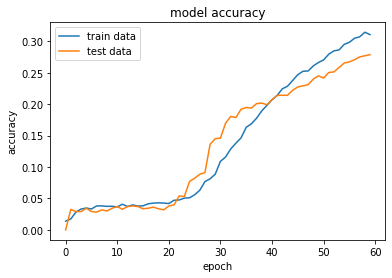

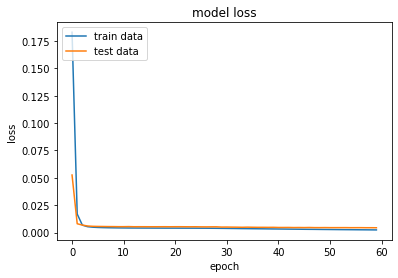

In [ ]:
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train data', 'test data'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train data', 'test data'], loc='upper left')
plt.show()

In [ ]:
import numpy as np
target_labels = encoder.classes_
for i in range(1,20):
    print()
    print("Actual label:",end=" ")
    print( test_labels.iloc[i])
    test_label = model.predict(np.array([x_test[i]]))
    print("Predicted label: ",end=" " )
    for i in range(3):
      j = np.argmax(test_label[0])
      predicted_label = target_labels[j]
      test_label[0][j] = 0;
      print(predicted_label, end = ", ")




Actual label: ['matplotlib', 'marker', 'scatter']
Predicted label:  python, matplotlib, numpy, 
Actual label: ['maven', 'markdown', 'maven-site-plugin']
Predicted label:  git, github, version-control, 
Actual label: ['python']
Predicted label:  python, generator, algorithm, 
Actual label: ['android', 'android-fragments']
Predicted label:  android, android-fragments, android-activity, 
Actual label: ['javascript', 'angularjs', 'checkbox', 'repeat']
Predicted label:  jquery, asp.net-mvc-3, asp.net-mvc, 
Actual label: ['html5', 'html5-audio']
Predicted label:  javascript, html, html5, 
Actual label: ['amazon-web-services', 'nosql', 'amazon-dynamodb']
Predicted label:  mysql, sql, database, 
Actual label: ['java', 'unit-testing', 'mockito']
Predicted label:  java, junit, multithreading, 
Actual label: ['java', 'collections']
Predicted label:  java, c#, collections, 
Actual label: ['ruby', 'string', 'substring', 'slice', 'idiomatic']
Predicted label:  ruby, regex, string, 
Actual label: ['

In [ ]:
def predict(str):
  test = tokenizer.texts_to_matrix([str], mode='tfidf')
  prediction = model.predict(np.array(test)) 
  print("text: "+ str)

  for i in range(3):
    j = np.argmax(prediction[0])
    predicted_label = target_labels[j]
    prediction[0][j] = 0;
    print("Predicted label: " + predicted_label)



 

In [ ]:
predict("Why is processing a sorted array faster than processing an unsorted array? Here is a piece of C++ code that shows some very peculiar behavior. For some strange reason, sorting the data (before the timed region) miraculously makes the loop almost six times faster.")

text: Why is processing a sorted array faster than processing an unsorted array? Here is a piece of C++ code that shows some very peculiar behavior. For some strange reason, sorting the data (before the timed region) miraculously makes the loop almost six times faster.
Predicted label: algorithm
Predicted label: string
Predicted label: c++


**Random Forest** **Classifier**

In [ ]:
reduced_df = data.head(2000)

In [ ]:
multilabel_binarizer = MultiLabelBinarizer()
encoded_labels = multilabel_binarizer.fit_transform(reduced_df['Tags'])

In [ ]:
encoded_labels.shape

(2000, 1643)

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

In [ ]:
tfidfVectorizer = TfidfVectorizer(analyzer = 'word',
                                       min_df=0.0,
                                       max_df = 1.0,
                                       encoding = 'utf-8', 
                                       token_pattern=r"(?u)\S\S+",
                                       max_features=1643)



In [ ]:
X1_tfidf = tfidfVectorizer.fit_transform(reduced_df['question'])


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X1_tfidf, encoded_labels, test_size = 0.2, random_state = 0) # Do 80/20 split


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)

y_pred = rfc.predict(X_test)



In [ ]:
from sklearn.metrics import hamming_loss
from sklearn.metrics import jaccard_score

# Function to get jacard score
def get_jacard():

    jscore = jaccard_score(y_test, y_pred, average='samples')
    
    return jscore

# Function to call jacard score and get hamming loss
def get_score():
    
    print("Jacard score: {}".format(get_jacard()))
    print("Hamming loss: {}".format(hamming_loss(y_pred, y_test)*100))
     

In [ ]:
get_score()

Jacard score: 0.19258333333333333
Hamming loss: 0.155203895313451


In [ ]:
X_train.shape

(1600, 1643)

In [ ]:
y_pred.shape

(400, 1643)